# Docling

Docling simplifies document processing, parsing diverse formats — including advanced PDF understanding — and providing seamless integrations with the gen AI ecosystem.

## References
[Docling: An Efficient Open-Source Toolkit for AI-driven Document Conversion](https://arxiv.org/pdf/2501.17887)  
[Docling Project](https://docling-project.github.io/docling/)

In [1]:
import sys
import os
import time
from pathlib import Path
import rich
from IPython.display import display, Markdown

## PDF Conversion

In [2]:
path_data = Path() / "data"
path_input = path_data / "raw"
path_output = path_data / "interim" / "docling"  # Store converted
path_output_chunks = path_data / "interim" / "chunks"

path_output.mkdir(exist_ok=True, parents=True)

In [3]:
path_artifacts = Path.home() / ".cache" / "docling" / "models"  # Docling models are stored here

path_artifacts.exists()

True

In [4]:
IMAGE_RESOLUTION_SCALE = 2.0  # scale=1 correspond of a standard 72 DPI image, also needed to get pages images

In [5]:
from docling.document_converter import DocumentConverter
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem


input_file = "Divulgacion Planetaria Althera.pdf"  # document per local path or URL
output_file = "Divulgacion-Planetaria-Althera.md"
input_doc_path = path_input / input_file


pipeline_options = PdfPipelineOptions(
    artifacts_path=path_artifacts.as_posix(),
    )
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True  # default
pipeline_options.table_structure_options.mode =  TableFormerMode.ACCURATE  # default, also FAST
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True


converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    },
)

# Conversion
tm_start = time.perf_counter()
conv_res = converter.convert(input_doc_path.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")


# Save the document as markdown
# Save pages as images
root_filename_elements = input_doc_path.stem

for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = path_output / f"{root_filename_elements}-{page_no}.png"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="PNG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-table-{table_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            path_output / f"{root_filename_elements}-picture-{picture_counter}.png"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "PNG")

2025-09-04 15:26:54,537 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-09-04 15:26:54,690 - INFO - Going to convert document batch...
2025-09-04 15:26:54,693 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 0fa808b112455bc067a1e2ac31d7699b
2025-09-04 15:26:54,763 - INFO - Loading plugin 'docling_defaults'
2025-09-04 15:26:54,781 - INFO - Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-09-04 15:27:02,327 - INFO - Accelerator device: 'cpu'
c:\Users\manua\Documents\repos\dslabs\dslab-docai\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-04 15:27:12,233 - INFO - Accelerator device: 'cpu'
2025-09-04 15:27:14,147 - INFO - Accelerator device: 'cpu'
2025-09-04 15:27:16,026 - INFO - Loading plugin 'docling_defaults'
2025-09-04 15:27:

tm_process=173.16 segs


`pipeline_options.table_structure_options.do_cell_matching=True` (default)
1. The table structure model infers the table structure
2. Attemps to fill the table structure with the original table cells from the pdf backend
If set to False:
2. Fill the table structure with the predicted cells content. This may improve output quality if you find that multiple columns in extracted tables are erroneously merged into one.

[Control PDF table extraction options](https://docling-project.github.io/docling/usage/#control-pdf-table-extraction-options)


## Conversion Confidence

In [6]:
type(conv_res.confidence)

docling.datamodel.base_models.ConfidenceReport

In [7]:
# Users can and should safely focus on the document-level grade fields — mean_grade and low_grade — to assess overall conversion quality
# https://docling-project.github.io/docling/concepts/confidence_scores/#purpose
print(f"{conv_res.confidence.mean_grade=}")
print(f"{conv_res.confidence.low_grade=}")

conv_res.confidence.mean_grade=<QualityGrade.EXCELLENT: 'excellent'>
conv_res.confidence.low_grade=<QualityGrade.EXCELLENT: 'excellent'>


# Docling Document

Pydantic data structure to set a structured interface to represent the document and its elements (tables, pictures, sections, etc.)

In [8]:
print(f"{type(conv_res)=}")
doc = conv_res.document
print(f"{type(doc)=}")

type(conv_res)=<class 'docling.datamodel.document.ConversionResult'>
type(doc)=<class 'docling_core.types.doc.document.DoclingDocument'>


In [9]:
# Save as json
doc.save_as_json(path_output / "docling-doc-Divulgacion-Planetaria-Althera.json")

### Document Structure

In [10]:
# Content items

print(f"{type(doc.texts)=}")
print(f"{type(doc.tables)=}")
print(f"{type(doc.pictures)=}")
print(f"{type(doc.key_value_items)=}")

type(doc.texts)=<class 'list'>
type(doc.tables)=<class 'list'>
type(doc.pictures)=<class 'list'>
type(doc.key_value_items)=<class 'list'>


#### Texts

In [11]:
rich.print(doc.texts[0])
# parent=RefItem(cref='#/body'),
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>, currently docling does not extract headers/footers

SectionHeaderItem(
    self_ref='#/texts/0',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=767.8590649804688,
                r=237.794,
                b=758.2620649804687,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='Divulgación Planetaria Althéra',
    text='Divulgación Planetaria Althéra',
    formatting=None,
    hyperlink=None,
    level=1
)

In [12]:
rich.print(doc.texts[1])
# parent=RefItem(cref='#/body')
# label=<DocItemLabel.SECTION_HEADER: 'section_header'>
# level=1

SectionHeaderItem(
    self_ref='#/texts/1',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=175.2,
                t=708.8030649804688,
                r=424.015,
                b=696.2400649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 37)
        )
    ],
    orig='Un nuevo y fascinante vecino: Althéra',
    text='Un nuevo y fascinante vecino: Althéra',
    formatting=None,
    hyperlink=None,
    level=1
)

In [13]:
rich.print(doc.texts[3])
# parent=RefItem(cref='#/groups/0'),
# content_layer=<ContentLayer.BODY: 'body'>,

ListItem(
    self_ref='#/texts/3',
    parent=RefItem(cref='#/groups/0'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.LIST_ITEM: 'list_item'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=94.44,
                t=663.3390649804688,
                r=259.716,
                b=653.7420649804687,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    enumerated=True,
    marker='1.'
)

In [14]:
rich.print(doc.texts[13])
# level=1

SectionHeaderItem(
    self_ref='#/texts/13',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=484.4230649804688,
                r=256.322,
                b=473.3720649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 30)
        )
    ],
    orig='1. Historia del descubrimiento',
    text='1. Historia del descubrimiento',
    formatting=None,
    hyperlink=None,
    level=1
)

In [15]:
rich.print(doc.texts[14])
# level=1

SectionHeaderItem(
    self_ref='#/texts/14',
    parent=RefItem(cref='#/body'),
    children=[],
    content_layer=<ContentLayer.BODY: 'body'>,
    label=<DocItemLabel.SECTION_HEADER: 'section_header'>,
    prov=[
        ProvenanceItem(
            page_no=1,
            bbox=BoundingBox(
                l=82.8,
                t=458.8100649804688,
                r=320.083,
                b=449.3650649804688,
                coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>
            ),
            charspan=(0, 48)
        )
    ],
    orig='1.1 Primeras observaciones y sospechas iniciales',
    text='1.1 Primeras observaciones y sospechas iniciales',
    formatting=None,
    hyperlink=None,
    level=1
)

#### Tables

In [16]:
len(doc.tables)

3

In [17]:
print(doc.tables[0].parent)
print(doc.tables[0].content_layer)

cref='#/body'
ContentLayer.BODY


In [18]:
display(Markdown(doc.tables[0].export_to_markdown(doc=doc)))

| Parámetro               | Althéra A   | Althéra B   |
|-------------------------|-------------|-------------|
| Masa                    | 1,28M ☉     | 0,82M ☉     |
| Radio                   | 1,32 R ☉    | 0,74 R ☉    |
| Luminosidad             | 2,4 L ☉     | 0,39 L ☉    |
| Temperatura superficial | 6.350 K     | 4.950K      |

In [19]:
display(Markdown(doc.tables[1].export_to_markdown(doc=doc)))

| Cuerpo                     | Tipo                 | Distancia media (UA)   | Periodo orbital (días terrestres)   |
|----------------------------|----------------------|------------------------|-------------------------------------|
| Thyros I ( HD 4579 Ab )    | Rocoso               | 0,78                   | 215                                 |
| Névalis II ( HD 4579 Ac )  | Rocoso               | 1,36                   | 397                                 |
| Cinturón de Arges          | Asteroides metálicos | 1,65 - 1,85            |                                     |
| Aurelia III ( HD 4579 Ad ) | Rocoso, habitable    | 2,21                   | 589                                 |

In [20]:
display(Markdown(doc.tables[2].export_to_markdown(doc=doc)))

| Cuerpo                     | Tipo            | Distancia media (UA)   |   Periodo orbital (días terrestres) |
|----------------------------|-----------------|------------------------|-------------------------------------|
| Zephyros IV ( HD 4579 Ae ) | Gigante gaseoso | 4,92                   |                               2.689 |
| Krion V ( HD 4579 Af )     | Gigante helado  | 8,14                   |                               6.873 |

#### Pictures

In [21]:
print(doc.pictures[0].parent)
print(doc.pictures[0].content_layer)

cref='#/body'
ContentLayer.BODY


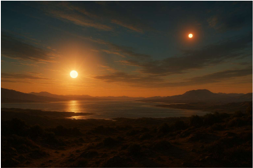

In [22]:
doc.pictures[0].get_image(doc=doc)

In [23]:
doc.pictures[0].footnotes

[]

In [24]:
doc.pictures[0].caption_text(doc=doc)

'Figure 1: Ocaso en Althéra'

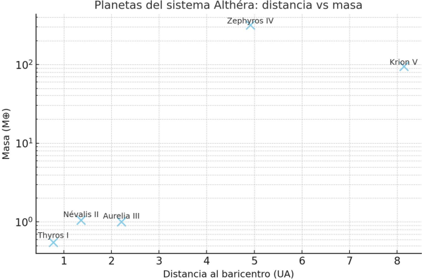

In [25]:
doc.pictures[1].get_image(doc=doc)


Figure 2: Notas del descubrimiento por la Dra. Maria Estay


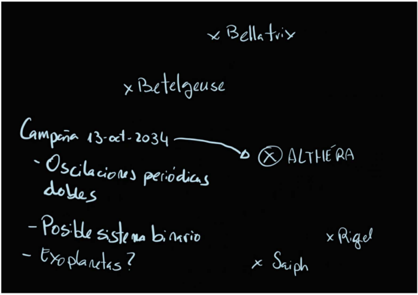

In [26]:
print(doc.pictures[2].caption_text(doc=doc))
doc.pictures[2].get_image(doc=doc)

In [27]:
doc.pictures[2].get_annotations()

[]

#### Key Value Items

In [28]:
doc.key_value_items

[]

### Export document to Markdown

In [29]:
# Remove headers
HEADERS = doc.texts[0].text

lst_el_headers = []
for el in doc.texts:
    if el.text == HEADERS:
        lst_el_headers.append(el)

if len(lst_el_headers) == 17:
    doc.delete_items(node_items=lst_el_headers)


2025-09-04 15:29:50,422 - INFO - deleted item in tree at stack: (167,) => #/texts/240
2025-09-04 15:29:50,424 - INFO - deleted item in tree at stack: (159,) => #/texts/229
2025-09-04 15:29:50,425 - INFO - deleted item in tree at stack: (154,) => #/texts/224
2025-09-04 15:29:50,427 - INFO - deleted item in tree at stack: (143,) => #/texts/213
2025-09-04 15:29:50,429 - INFO - deleted item in tree at stack: (131,) => #/texts/199
2025-09-04 15:29:50,431 - INFO - deleted item in tree at stack: (121,) => #/texts/179
2025-09-04 15:29:50,432 - INFO - deleted item in tree at stack: (107,) => #/texts/159
2025-09-04 15:29:50,434 - INFO - deleted item in tree at stack: (96,) => #/texts/144
2025-09-04 15:29:50,436 - INFO - deleted item in tree at stack: (83,) => #/texts/116
2025-09-04 15:29:50,438 - INFO - deleted item in tree at stack: (72,) => #/texts/104
2025-09-04 15:29:50,439 - INFO - deleted item in tree at stack: (64,) => #/texts/82
2025-09-04 15:29:50,441 - INFO - deleted item in tree at st

In [30]:
# Parse handwritten images

filename_img3 = path_output / "Divulgacion Planetaria Althera-picture-3.png"

img_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.IMAGE,
            ],  # whitelist formats, non-matching files are ignored.
        )
    )

tm_start = time.perf_counter()
conv_res_img3 = img_converter.convert(filename_img3.as_posix())
tm_end = time.perf_counter()
tm_process = tm_end - tm_start
print(f"{tm_process=:0.2f} segs")

for i, el_text in enumerate(conv_res_img3.document.texts):
    print(f"{el_text.text=}")
    # Results with Tesseract may improve


2025-09-04 15:29:50,540 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-09-04 15:29:52,088 - INFO - Going to convert document batch...
2025-09-04 15:29:52,088 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 130b240947e51886114a732a44356305
2025-09-04 15:29:52,088 - INFO - Accelerator device: 'cpu'
2025-09-04 15:29:59,622 - INFO - Accelerator device: 'cpu'
2025-09-04 15:30:01,770 - INFO - Accelerator device: 'cpu'
2025-09-04 15:30:03,214 - INFO - Processing document Divulgacion Planetaria Althera-picture-3.png
c:\Users\manua\Documents\repos\dslabs\dslab-docai\.venv\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-09-04 15:30:22,951 - INFO - Finished converting document Divulgacion Planetaria Althera-picture-3.png in 32.42 sec.


tm_process=32.44 segs
el_text.text='do'
el_text.text='13-cl - 2034'
el_text.text='Osclacous'
el_text.text='Eyo'
el_text.text='Perodas'
el_text.text='Althe Pa'


In [31]:
doc.pictures[2].captions

[RefItem(cref='#/texts/225')]

In [32]:
# Fix an element
doc.pictures[2].footnotes = 'Figure 2: Notas del descubrimiento por la Dra. Maria Estay'
doc.texts[225].text = "Bellatrix\nBetelgeuse\nCampaña 13-oct-2024\n- Oscilaciones periódicas\n- Posible sistema binario\n- Exoplanetas? \nALTHÉRA\nRigel\nSaiph"

# Elements can be inserted, removed and so on. Check Reference
# https://docling-project.github.io/docling/reference/docling_document/#docling_core.types.doc.DoclingDocument

In [33]:
# Save markdown with references to images
doc.save_as_markdown(
    (path_output / "Divulgacion-Planetaria-Althera-wimgtb.md").as_posix(),   # creates a folder for artifacts
    image_mode=ImageRefMode.REFERENCED 
    )

# Save markdown with no references to images
doc.save_as_markdown(
    (path_output / output_file).as_posix(),
    image_mode=ImageRefMode.PLACEHOLDER  
    )
 
# Export to markdown
res_md = doc.export_to_markdown()          
display(Markdown(res_md[:1000]))

## Un nuevo y fascinante vecino: Althéra

## Índice

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

## 1. Historia del descubrimiento

## 1.1 Primeras observaciones y sospechas iniciales

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas en órbita mutua y vari

### Document Structure

In [34]:
# Content structure items

print(f"{type(doc.body)=}")  # all elements: texts, pictures, tables and groups
print(f"{type(doc.furniture)=}")  # elements outside body
print(f"{type(doc.groups)=}")  # pieces of text like lists and so on

type(doc.body)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.furniture)=<class 'docling_core.types.doc.document.GroupItem'>
type(doc.groups)=<class 'list'>


C:\Users\manua\AppData\Local\Temp\ipykernel_19256\1248164015.py:4: DeprecationWarning: deprecated
  print(f"{type(doc.furniture)=}")  # elements outside body


In [35]:
doc.furniture

C:\Users\manua\AppData\Local\Temp\ipykernel_19256\970953479.py:1: DeprecationWarning: deprecated
  doc.furniture


GroupItem(self_ref='#/furniture', parent=None, children=[], content_layer=<ContentLayer.FURNITURE: 'furniture'>, name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>)

In [36]:
doc.groups

[ListGroup(self_ref='#/groups/0', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/2'), RefItem(cref='#/texts/3'), RefItem(cref='#/texts/4'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/texts/7'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/texts/10'), RefItem(cref='#/texts/11')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/2', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/26'), RefItem(cref='#/texts/27'), RefItem(cref='#/texts/28')], content_layer=<ContentLayer.BODY: 'body'>, name='list', label=<GroupLabel.LIST: 'list'>),
 ListGroup(self_ref='#/groups/3', parent=RefItem(cref='#/body'

In [37]:
rich.print(doc.groups[0])

ListGroup(
    self_ref='#/groups/0',
    parent=RefItem(cref='#/body'),
    children=[
        RefItem(cref='#/texts/2'),
        RefItem(cref='#/texts/3'),
        RefItem(cref='#/texts/4'),
        RefItem(cref='#/texts/5'),
        RefItem(cref='#/texts/6'),
        RefItem(cref='#/texts/7'),
        RefItem(cref='#/texts/8'),
        RefItem(cref='#/texts/9'),
        RefItem(cref='#/texts/10'),
        RefItem(cref='#/texts/11')
    ],
    content_layer=<ContentLayer.BODY: 'body'>,
    name='list',
    label=<GroupLabel.LIST: 'list'>
)

In [38]:
for el_child in doc.groups[0].children:
    el_child_ref = el_child.cref.split("/")  # #/texts/N
    el_child_kind = el_child_ref[1]
    el_child_id = int(el_child_ref[2])
    if el_child_kind == "texts":
        el_child_id_text = doc.texts[el_child_id].text
        print(f"{el_child_id}: {el_child_id_text} ")

2: Historia del descubrimiento 
3: Conoce a Althéra 
4: Los soles de Althéra 
5: Estructura general de Althéra 
6: Planetas interiores 
7: Planetas exteriores 
8: Lunas y satélites menores 
9: Fenómenos destacados 
10: Habitabilidad y astrobiología 
11: Conclusiones y perspectivas futuras 


In [39]:
for el_child in doc.groups[1].children:
    el_child_ref = el_child.cref.split("/")  # #/texts/N
    el_child_kind = el_child_ref[1]
    el_child_id = int(el_child_ref[2])
    if el_child_kind == "texts":
        el_child_id_text = doc.texts[el_child_id].text
        print(f"{el_child_id}: {el_child_id_text} ")

17: ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución. 
18: Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos. 
19: Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros orbitales del sistema. 


In [40]:
rich.print(doc.body )  # root of the document layout

GroupItem(
    self_ref='#/body',
    parent=None,
    children=[
        RefItem(cref='#/texts/0'),
        RefItem(cref='#/texts/1'),
        RefItem(cref='#/groups/0'),
        RefItem(cref='#/texts/12'),
        RefItem(cref='#/texts/13'),
        RefItem(cref='#/texts/14'),
        RefItem(cref='#/texts/15'),
        RefItem(cref='#/texts/16'),
        RefItem(cref='#/groups/1'),
        RefItem(cref='#/texts/20'),
        RefItem(cref='#/texts/21'),
        RefItem(cref='#/texts/22'),
        RefItem(cref='#/texts/23'),
        RefItem(cref='#/texts/24'),
        RefItem(cref='#/texts/25'),
        RefItem(cref='#/groups/2'),
        RefItem(cref='#/texts/29'),
        RefItem(cref='#/texts/30'),
        RefItem(cref='#/texts/31'),
        RefItem(cref='#/texts/32'),
        RefItem(cref='#/texts/33'),
        RefItem(cref='#/texts/34'),
        RefItem(cref='#/texts/35'),
        RefItem(cref='#/texts/36'),
        RefItem(cref='#/texts/37'),
        RefItem(cref='#/groups/3'),
        RefItem(cref='#/texts/40'),
        RefItem(cref='#/texts/41'),
        RefItem(cref='#/texts/42'),
        RefItem(cref='#/texts/43'),
        RefItem(cref='#/texts/44'),
        RefItem(cref='#/groups/4'),
        RefItem(cref='#/texts/48'),
        RefItem(cref='#/texts/49'),
        RefItem(cref='#/texts/50'),
        RefItem(cref='#/texts/51'),
        RefItem(cref='#/texts/52'),
        RefItem(cref='#/texts/53'),
        RefItem(cref='#/texts/54'),
        RefItem(cref='#/groups/5'),
        RefItem(cref='#/texts/57'),
        RefItem(cref='#/texts/58'),
        RefItem(cref='#/texts/59'),
        RefItem(cref='#/pictures/0'),
        RefItem(cref='#/texts/61'),
        RefItem(cref='#/tables/0'),
        RefItem(cref='#/texts/62'),
        RefItem(cref='#/texts/63'),
        RefItem(cref='#/texts/64'),
        RefItem(cref='#/texts/65'),
        RefItem(cref='#/texts/66'),
        RefItem(cref='#/texts/67'),
        RefItem(cref='#/groups/6'),
        RefItem(cref='#/texts/71'),
        RefItem(cref='#/texts/72'),
        RefItem(cref='#/texts/73'),
        RefItem(cref='#/texts/74'),
        RefItem(cref='#/texts/75'),
        RefItem(cref='#/texts/76'),
        RefItem(cref='#/texts/77'),
        RefItem(cref='#/texts/78'),
        RefItem(cref='#/pictures/1'),
        RefItem(cref='#/texts/95'),
        RefItem(cref='#/tables/1'),
        RefItem(cref='#/texts/96'),
        RefItem(cref='#/tables/2'),
        RefItem(cref='#/texts/97'),
        RefItem(cref='#/groups/7'),
        RefItem(cref='#/texts/101'),
        RefItem(cref='#/texts/102'),
        RefItem(cref='#/texts/103'),
        RefItem(cref='#/texts/104'),
        RefItem(cref='#/texts/105'),
        RefItem(cref='#/texts/106'),
        RefItem(cref='#/texts/107'),
        RefItem(cref='#/texts/108'),
        RefItem(cref='#/texts/109'),
        RefItem(cref='#/groups/8'),
        RefItem(cref='#/texts/117'),
        RefItem(cref='#/texts/118'),
        RefItem(cref='#/groups/9'),
        RefItem(cref='#/texts/122'),
        RefItem(cref='#/groups/10'),
        RefItem(cref='#/texts/126'),
        RefItem(cref='#/texts/127'),
        RefItem(cref='#/groups/11'),
        RefItem(cref='#/texts/134'),
        RefItem(cref='#/texts/135'),
        RefItem(cref='#/texts/136'),
        RefItem(cref='#/texts/137'),
        RefItem(cref='#/texts/138'),
        RefItem(cref='#/texts/139'),
        RefItem(cref='#/texts/140'),
        RefItem(cref='#/texts/141'),
        RefItem(cref='#/texts/142'),
        RefItem(cref='#/groups/12'),
        RefItem(cref='#/texts/148'),
        RefItem(cref='#/texts/149'),
        RefItem(cref='#/texts/150'),
        RefItem(cref='#/texts/151'),
        RefItem(cref='#/groups/13'),
        RefItem(cref='#/texts/154'),
        RefItem(cref='#/texts/155'),
        RefItem(cref='#/groups/14'),
        RefItem(cref='#/texts/162'),
        RefItem(cref='#/texts/163'),
        RefItem(cref='#/groups/15'),
        RefItem(cref='#/texts/165'),
      

## Chunking

#### Hierarchical

Attemps to merge some elements from the document body.

In [41]:
from docling.chunking import HybridChunker, HierarchicalChunker
import tiktoken
import pandas as pd
from docling_core.transforms.chunker.tokenizer.openai import OpenAITokenizer
tokenizer = OpenAITokenizer(
    tokenizer=tiktoken.encoding_for_model("gpt-4o"),
    max_tokens=2048,  # context window length required for OpenAI tokenizers
)

chunker = HierarchicalChunker(
    merge_list_items=True,
    
)
chunk_iter = chunker.chunk(dl_doc=doc)
lst_chunks = list(chunk_iter)
lst_chunk_sizes = [tokenizer.count_tokens(x.text) for x in lst_chunks]
se_chunk_analisis = pd.Series(lst_chunk_sizes).describe()

print("Hierarchical Chunking analysis:")
se_chunk_analisis

2025-09-04 15:30:26,457 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
2025-09-04 15:30:26,494 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
2025-09-04 15:30:26,509 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


Hierarchical Chunking analysis:


count     89.000000
mean      80.000000
std       48.270074
min        5.000000
25%       47.000000
50%       69.000000
75%      105.000000
max      246.000000
dtype: float64

In [42]:
rich.print(lst_chunks[0].text)


1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

In [43]:
rich.print(lst_chunks[1].text)


El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [44]:
rich.print(
    chunker.contextualize(chunk=lst_chunks[1])
    )


1.1 Primeras observaciones y sospechas iniciales
El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [45]:
# Contextualize: Add some metadata and references
rich.print(
    chunker.contextualize(chunk=lst_chunks[25])
    )
# Table?
rich.print(
    chunker.contextualize(chunk=lst_chunks[26])
    )

3.2 Masas, radios y luminosidades comparadas
El sistema binario Althéra está formado por dos estrellas de características bien contrastadas: Althéra A , más 
masiva y luminosay Althéra B , más pequeña y fría. Aunque la luminosidad de Althéra A domina el aporte energético 
global, la presencia de Althéra B, ☉ , actúa como un regulador térmico que suaviza las variaciones extremas de 
temperatura en la zona habitable, contribuyendo a su estabilidad a largo plazo.

3.2 Masas, radios y luminosidades comparadas
Figure 1: Ocaso en Althéra

In [46]:
rich.print(
    lst_chunks[25].text
    )
# Table?
rich.print(
    lst_chunks[26].text
    )

El sistema binario Althéra está formado por dos estrellas de características bien contrastadas: Althéra A , más 
masiva y luminosay Althéra B , más pequeña y fría. Aunque la luminosidad de Althéra A domina el aporte energético 
global, la presencia de Althéra B, ☉ , actúa como un regulador térmico que suaviza las variaciones extremas de 
temperatura en la zona habitable, contribuyendo a su estabilidad a largo plazo.

Figure 1: Ocaso en Althéra

#### HybridChunker

It starts from the result of the hierarchical chunker and, based on the user-provided tokenizer (typically to be aligned to the embedding model tokenizer), it:
* does one pass where it splits chunks only when needed (i.e. oversized w.r.t. tokens), &
* another pass where it merges chunks only when possible (i.e. undersized successive chunks with same headings & captions) — users can opt out of this step via param merge_peers (by default True)


(Recommended option)

In [47]:
chunker_hybrid = HybridChunker(
    tokenizer=tokenizer,
    merge_list_items=True,
    merge_peers=True,
)

chunk_iter = chunker_hybrid.chunk(dl_doc=doc)
lst_chunks_hybrid = list(chunk_iter)
lst_chunk_sizes_hybrid  = [tokenizer.count_tokens(x.text) for x in lst_chunks_hybrid ]
se_chunk_analisis_hybrid  = pd.Series(lst_chunk_sizes_hybrid ).describe()

print("Hybrid Chunking analysis:")
se_chunk_analisis_hybrid 

2025-09-04 15:30:27,037 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
2025-09-04 15:30:27,054 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.
2025-09-04 15:30:27,076 - WARNING - Usage of TableItem.export_to_dataframe() without `doc` argument is deprecated.


Hybrid Chunking analysis:


count     42.000000
mean     169.690476
std      108.547952
min       47.000000
25%       99.250000
50%      140.000000
75%      207.750000
max      517.000000
dtype: float64

In [48]:
rich.print(lst_chunks_hybrid[0].text)

1. Historia del descubrimiento
2. Conoce a Althéra
3. Los soles de Althéra
4. Estructura general de Althéra
5. Planetas interiores
6. Planetas exteriores
7. Lunas y satélites menores
8. Fenómenos destacados
9. Habitabilidad y astrobiología
10. Conclusiones y perspectivas futuras

In [49]:
rich.print(lst_chunks_hybrid[1].text)

El sistema binario Althéra ( HD 4579 AB ) fue detectado por primera vez en el año 2032 durante una campaña de 
observación del Observatorio Espacial James Webb , dirigida por la astrofísica chilena Dra. Mariela Estay . La 
misión principal era estudiar la composición atmosférica de exoplanetas candidatos a la habitabilidad, pero un 
patrón anómalo en el flujo luminoso proveniente de la constelación de Orión llamó la atención del equipo. El 
análisis de curvas de luz reveló oscilaciones periódicas dobles, un indicio claro de la presencia de dos estrellas 
en órbita mutua y varios cuerpos orbitando de forma circumbinaria.

In [50]:
rich.print(lst_chunks_hybrid[2].text)

En los meses siguientes, un consorcio internacional liderado por la Agencia Espacial Europea (ESA) y el Instituto 
Max Planck de Astronomía desplegó observaciones complementarias utilizando:
- ELT (Extremely Large Telescope) en el Desierto de Atacama para espectroscopía de alta resolución.
- Telescopio Espacial Nancy Grace Roman para fotometría de gran precisión en tránsitos.
- Interferometría de radio desde la red Very Long Baseline Array (VLBA) para afinar la distancia y parámetros 
orbitales del sistema.
Fue el equipo del astrónomo estadounidense Dr. Jonathan Kepler-Saunders quien confirmó, mediante el método de 
velocidad radial ultraestable, la existencia de cinco planetas principales y varios cinturones de escombros.

In [51]:
rich.print(
    chunker.contextualize(chunk=lst_chunks_hybrid[9])
    )
rich.print(
    chunker.contextualize(chunk=lst_chunks[10])
    )

3.2 Masas, radios y luminosidades comparadas
El sistema binario Althéra está formado por dos estrellas de características bien contrastadas: Althéra A , más 
masiva y luminosay Althéra B , más pequeña y fría. Aunque la luminosidad de Althéra A domina el aporte energético 
global, la presencia de Althéra B, ☉ , actúa como un regulador térmico que suaviza las variaciones extremas de 
temperatura en la zona habitable, contribuyendo a su estabilidad a largo plazo.
Figure 1: Ocaso en Althéra
Masa, Althéra A = 1,28M ☉. Masa, Althéra B = 0,82M ☉. Radio, Althéra A = 1,32 R ☉. Radio, Althéra B = 0,74 R ☉. 
Luminosidad, Althéra A = 2,4 L ☉. Luminosidad, Althéra B = 0,39 L ☉. Temperatura superficial, Althéra A = 6.350 K. 
Temperatura superficial, Althéra B = 4.950K
La diferencia de luminosidad significa que, aunque Althéra A domina el aporte energético, Althéra B contribuye de 
manera significativa a la estabilidad térmica del sistema, suavizando las variaciones extremas en la zona 
habitable.

2.1 Localización en la galaxia
El sistema binario Althéra ( HD 4579 AB ) se encuentra en el brazo de Orión de la Vía Láctea , a una distancia de 
42,7 años luz de la Tierra. Su posición aparente en el cielo

In [52]:
rich.print(
    chunker.contextualize(chunk=lst_chunks[-1])
    )

Anexo: Miscelánea
Bellatrix
Betelgeuse
Campaña 13-oct-2024
- Oscilaciones periódicas
- Posible sistema binario
- Exoplanetas? 
ALTHÉRA
Rigel
Saiph

## Store chunks

In [53]:
path_output_chunks.mkdir(exist_ok=True, parents=True)



In [54]:
dc_chunks = ...